# Prostate Cancer Worshop

## Initial analysis

### Imports

In [18]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from IPython.display import display 
from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import lightgbm as lgb
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore") 

### LoadingData

In [9]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

df_train.shape

(23494, 46)

In [10]:
df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [28]:
numeric_columns = [
    'Cant_gr_flia', 
    'Cant_riesgos_flia_mean', 
    'cantidad_serv_flia', 
    'CANTIDAD_SERVICIOS', 
    'conteo_dx_diferentes', 
    'EDAD', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'Pendiente', 
    'Pendiente_flia', 
    'Promedio_costo', 
    'Promedio_costo_flia', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'MEDICAMENTOS', 
    'MEDICINA ESPECIALIZADA', 
    'MEDICINA GENERAL', 
    'TIEMPO_AFILIACION', 
    'TIEMPO_ULTIMA_CITA', 
    'PERDIDA_DE_PESO', 
    'Intercepto', 
    'Intercepto_flia', 
    'Target', 
    'Cant_Fliar_CP', 
    'Cant_Fliar_riesgos'
]

categorical_columns = [
    'AGRUPACION_DIASTOLICA', 
    'AGRUPACION_SISTOLICA', 
    'CANCER_MAMA_FAMILIAR', 
    'CANCER_OTRO_SITIO', 
    'CORONARIOS', 
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR', 
    'CEREBRAL', 
    'CEREBRAL_FAMILIAR', 
    'DIABETES', 
    'DIABETES_FAMILIAR', 
    'ENFERMEDAD_RENAL', 
    'ENFERMEDAD_RENAL_FAMILIAR', 
    'HIPERTENSION', 
    'HIPERTENSION_FAMILIAR', 
    'OTROS_ANTECEDENTES_VASCULARES', 
    'RIESGOS', 
    'ESTADO_CIVI', 
    'estrato', 
    'parentesco', 
    'PROGRAMA', 
]

In [29]:
ordinal_columns = [
    'AGRUPACION_DIASTOLICA',
    'AGRUPACION_SISTOLICA',
    'HIPERTENSION',
    'HIPERTENSION_FAMILIAR',
    'RIESGOS',
    'estrato'
]

nominal_columns = [
    'CANCER_MAMA_FAMILIAR',
    'CANCER_OTRO_SITIO',
    'CORONARIOS',
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR',
    'CEREBRAL',
    'CEREBRAL_FAMILIAR',
    'DIABETES',
    'DIABETES_FAMILIAR',
    'ENFERMEDAD_RENAL',
    'ENFERMEDAD_RENAL_FAMILIAR',
    'OTROS_ANTECEDENTES_VASCULARES',
    'ESTADO_CIVI',
    'parentesco',
    'PROGRAMA'                  
]



### Feature Importance

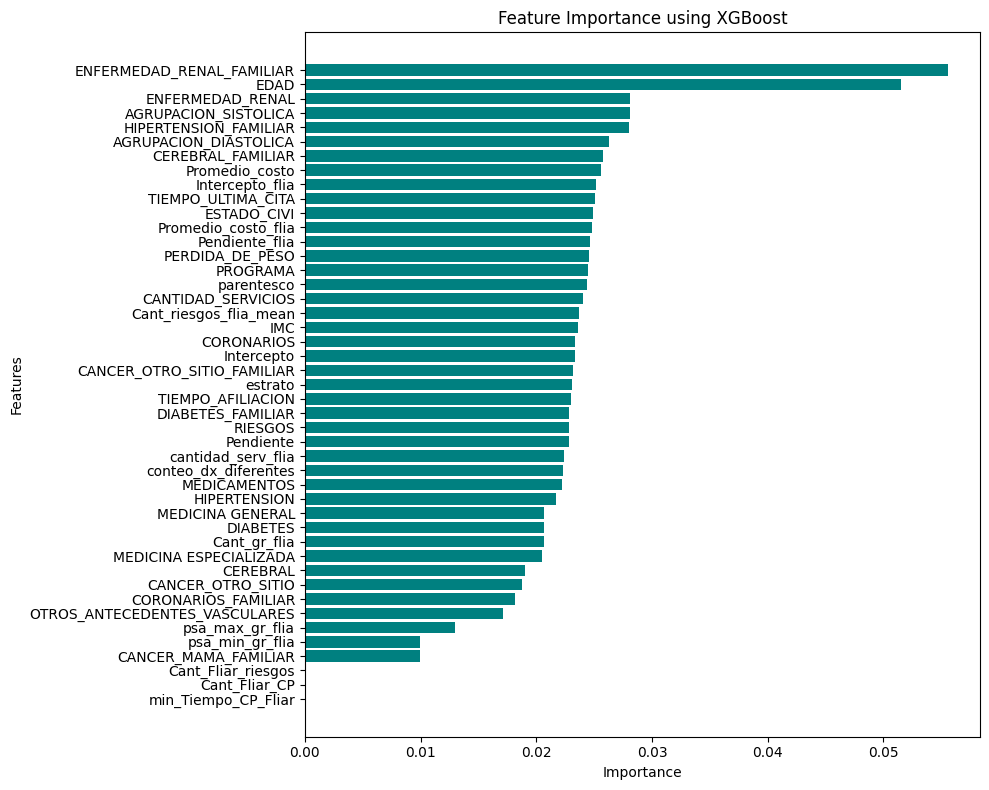

In [12]:
df_encoded = df_train.copy()
for column in ordinal_columns + nominal_columns + ['IMC']:
    df_encoded[column] = df_encoded[column].astype('category')
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
features_to_drop = ['Cant_Fliar_riesgos', 'Cant_Fliar_CP', 'min_Tiempo_CP_Fliar', 'psa_min_gr_flia', 'psa_max_gr_flia', 'CANCER_MAMA_FAMILIAR']

### Validate dropping features
- In order to be sure whether we decide to drop or not the already identified features, we will run a preliminary model to test with and without the features

In [27]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

# Model 1: With all features
X_all_features = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

f1_all_features = train_and_evaluate(X_all_features, y)
print(f"F1 Score with all features: {f1_all_features}")

# Model 2: Dropping variables with zero importance
X_reduced_features = df_encoded.drop(columns=['Target'] + features_to_drop)

f1_reduced_features = train_and_evaluate(X_reduced_features, y)
print(f"F1 Score after dropping zero-importance features: {f1_reduced_features}")

F1 Score with all features: 0.5206929740134745
F1 Score after dropping zero-importance features: 0.5384252710985383


After dropping additional features, including `'Cant_Fliar_riesgos'`, `'Cant_Fliar_CP'`, `'min_Tiempo_CP_Fliar'`, `'psa_min_gr_flia'`, `'psa_max_gr_flia'`, and `'CANCER_MAMA_FAMILIAR'`, the model's performance improved. The F1 score increased from **0.5207** (with all features) to **0.5384** (after removing these features), indicating that simplifying the model by excluding both zero-importance features and those with minimal predictive power can enhance the model’s performance. By reducing noise from less significant features, the model was able to generalize better and make more accurate predictions, showcasing the benefits of feature selection in machine learning.

## Preprocessing Pipeline_________________________________________________

In [35]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('ord', ordinal_transformer, ordinal_columns),
        ('nom', nominal_transformer, nominal_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('drop_columns', 'passthrough'),
    ('preprocessor', preprocessor)
])

#### Applying preprocessor pipeline
- Imputation and dropping

In [43]:
X = df_train.drop(columns=features_to_drop)
y = df_train['Target']

pipeline.fit(X)
X_train_transformed = pipeline.transform(X)


#### Converting the pipeline output into a readable data frame

In [55]:

transformed_columns = (
    numeric_columns + 
    ordinal_columns + 
    list(pipeline.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names_out(nominal_columns))
)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_train_transformed_df

,Cant_gr_flia,Cant_riesgos_flia_mean,cantidad_serv_flia,CANTIDAD_SERVICIOS,conteo_dx_diferentes,EDAD,Pendiente,Pendiente_flia,Promedio_costo,Promedio_costo_flia,...,parentesco_Conyuge,parentesco_Hijo,parentesco_None,parentesco_Otros,parentesco_Padres,parentesco_Sin Descripcion,parentesco_Trabajador,PROGRAMA_PAC,PROGRAMA_POS,PROGRAMA_RS
0,2.0,0.0,34.0,14.0,5.0,55.0,58373.057143,15998.485714,1.885690e+05,48947.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,0.5,25.0,9.0,3.0,55.0,19618.942857,655.200000,9.747050e+04,7644.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.0,36.0,17.0,5.0,59.0,398534.000000,342236.971429,2.304723e+06,1013991.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,0.0,24.0,4.0,3.0,55.0,1292.600000,-4468.285714,5.380450e+04,22572.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,7.0,6.0,3.0,53.0,13728.714286,0.000000,4.134967e+04,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,3.0,0.0,22.0,2.0,1.0,55.0,6628.571429,18670.800000,4.640000e+04,99173.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23490,1.0,1.0,11.0,7.0,3.0,49.0,36161.142857,462.857143,9.038500e+04,3240.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23491,1.0,0.0,15.0,11.0,5.0,53.0,15912.885714,5247.171429,1.078278e+05,38615.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23492,1.0,0.0,4.0,2.0,2.0,56.0,2685.571429,40.000000,1.879900e+04,280.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
